In [1]:
import numpy as np
import h5py
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import gridspec
from matplotlib.colors import colorConverter
plt.rc('text', usetex=True)

import seaborn as sns

import glob
import os
import pickle
import sys

from astropy.table import Table


In [2]:
from colossus.halo import mass_adv
from colossus.cosmology import cosmology
cosmology.setCosmology('planck18')

In [3]:
def open_pkl(file_name):
    pkl = open(file_name,'rb')
    array = pickle.load(pkl)#, encoding='latin')
    pkl.close()  
    return array

In [4]:
def get_median(bins, x, y):
    
    x_y =np.vstack([x,y])
    
    bins_y=[]
    bins_x=[]
    
    for i in range(len(bins)-1):
        l=bins[i]
        u=bins[i+1]
        
        mask = [(x_y[0]>l) & (x_y[0]<u)]

        y_in_range = x_y[1][mask]
        x_in_range = x_y[0][mask]
        
#         print(len(y_in_range))
        
        bins_y.append(np.median(y_in_range))
        bins_x.append(np.median(x_in_range))
        
    return bins_x, bins_y
               

In [5]:
def make_Mstar_Mhalo_plot(HSC_data, mass_radius, Illustris_data=None, TNG_data=None, output_filename=None):
    
    mass_bins = np.linspace(13.0,14.25,4)
    
    fig = plt.figure(figsize=[10,10])

    #hsc
    hsc_mvir = np.array(HSC_data['m_vir'])
    hsc_mstar = np.array(HSC_data['m_{0}'.format(mass_radius)])

    sns.kdeplot(hsc_mvir, hsc_mstar, cmap="Greys", shade=True, shade_lowest=False, legend=False,  n_levels=7,
                zorder =1)
    contours_ax = sns.kdeplot(hsc_mvir, hsc_mstar, colors='grey', cmap=None, shade_lowest=False,
                              n_levels=7, linewidths=1)
    
    #only show scatter points outside the contours: https://stackoverflow.com/questions/19311957/plot-contours-for-the-densest-region-of-a-scatter-plot
    inside = np.full_like(hsc_mvir,False,dtype=bool)
    for level in contours_ax.collections[1].get_paths():
        inside |= level.contains_points(zip(*(hsc_mvir, hsc_mstar)))
    plt.scatter(hsc_mvir[~inside], hsc_mstar[~inside], marker='o', color='k',
                s=1, linewidth=0, alpha=1, zorder=0)
    ############

    bins_x_hsc, bins_y_hsc = get_median(mass_bins, hsc_mvir, hsc_mstar)
    plt.plot(bins_x_hsc, bins_y_hsc, markersize=20, color=colorConverter.to_rgba('k', alpha=.4),
             linewidth=5, marker='s', zorder=5, markeredgecolor=colorConverter.to_rgba('k', alpha=1), 
             markeredgewidth=3, label='HSC') #medians
    
    if Illustris_data:
        illustris_mvir = np.array(Illustris_data['m_vir'])
        illustris_mstar = np.array(Illustris_data['m_1d_{0}'.format(mass_radius)])
        plt.scatter(illustris_mvir, illustris_mstar, color=u'#d62728', s=30, linewidth=0,
                    zorder=5)
        bins_x_illustris, bins_y_illustris = get_median(mass_bins, illustris_mvir, illustris_mstar)
        plt.plot(bins_x_illustris, bins_y_illustris, markersize=20,
                 color=colorConverter.to_rgba(u'#d62728', alpha=.5), linewidth=5, marker='s', zorder=6,
                 markeredgecolor=colorConverter.to_rgba(u'#d62728', alpha=1), markeredgewidth=3,
                 label='Illustris')#medians
    if TNG_data:
        tng_mvir = np.array(TNG_data['m_vir'])
        tng_mstar = np.array(TNG_data['m_1d_{0}'.format(mass_radius)])
        plt.scatter(tng_mvir, tng_mstar, color=u'#1f77b4', s=30, linewidth=0, zorder=5)
        
        bins_x_tng, bins_y_tng = get_median(mass_bins, tng_mvir, tng_mstar)
        plt.plot(bins_x_tng, bins_y_tng, markersize=20, color=colorConverter.to_rgba(u'#1f77b4', alpha=.5),
                 linewidth=5, marker='s', zorder=6, markeredgecolor=colorConverter.to_rgba('b', alpha=1),
                label='TNG', markeredgewidth=3)#medians


    #make cut to include M_100>11.5
    plt.axvline(13.0, c='grey', linewidth=1, linestyle='--')
    plt.axhline(11.2, c='grey', linewidth=1, linestyle='--')

    plt.xlabel('$\log (M_{vir})$', fontsize=40)
    plt.ylabel(r'$\log (M_{{\star,  {0}  \mathrm{{kpc}}}})$'.format(str(mass_radius)), fontsize=40)

    plt.tick_params(axis='both', which='major', labelsize=30)

    plt.xlim([12,14.25])
    if mass_radius ==10:
        plt.ylim([10.5,11.75])
    else:
            plt.ylim([11,12.2])

    #legend
    lgnd = plt.legend(fontsize=30, scatterpoints=1, frameon=False)#, markerscale=2.)#, handler_map={hsc_points: HandlerLine2D(numpoints=3)})
    #change the marker size manually for both lines
#     lgnd.legendHandles[0]._sizes = [20.]

    if output_filename:
        fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/{0}'.format(output_filename),
                dpi=100, format='pdf', bbox_inches='tight')
    else:
        fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/Mhalo_vs_M{0}.pdf'.format(str(mass_radius)),
                    dpi=100, format='pdf', bbox_inches='tight')



    plt.show()
    
    return

# files

## simulations

In [6]:
illustris_masses_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/Illustris_masses_highres.pkl'
tng_masses_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/TNG_masses_highres.pkl'
illustris_masses = open_pkl(illustris_masses_file)
tng_masses = open_pkl(tng_masses_file)


### HSC

In [7]:
hsc_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/HSC/s16a_mass_good_mhalo_frac4_180503.fits'
hsc_table = Table.read(hsc_file)

In [8]:
hsc_m_vir_sr = hsc_table['logmh_vir_symbol']
hsc_m_vir_rf = hsc_table['logmh_vir_forest']

hsc_m100 = hsc_table['logm_100']
hsc_m30 = hsc_table['logm_30']
hsc_m10 = hsc_table['logm_10']

In [9]:
# HSC_data = {'m_vir':hsc_m_vir_sr[:100], 'm_100':hsc_m100[:10000], 'm_30':hsc_m30[:10000], 'm_10':hsc_m10[:10000]}
HSC_data = {'m_vir':hsc_m_vir_sr[:], 'm_100':hsc_m100[:], 'm_30':hsc_m30[:], 'm_10':hsc_m10[:]}

# PLOTS 

/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:15: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(s

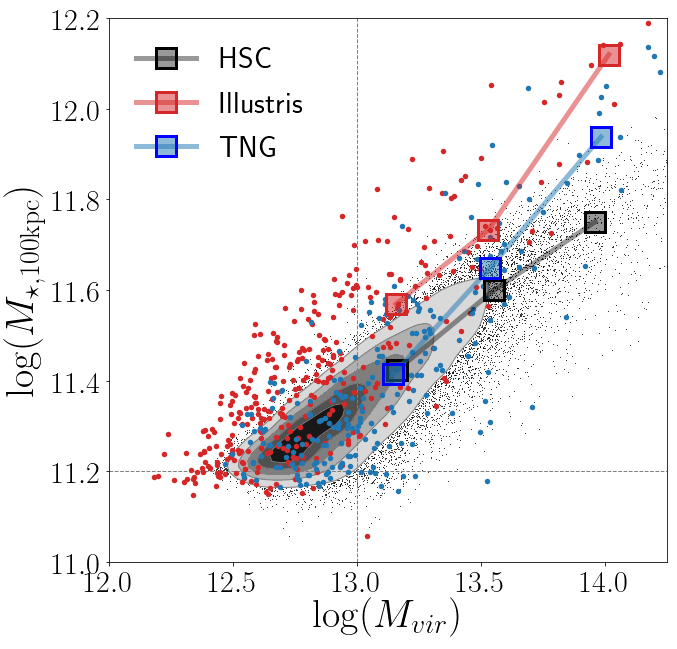

In [10]:
make_Mstar_Mhalo_plot(HSC_data,  100, Illustris_data = illustris_masses,
                     TNG_data = tng_masses)
                      

/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:15: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


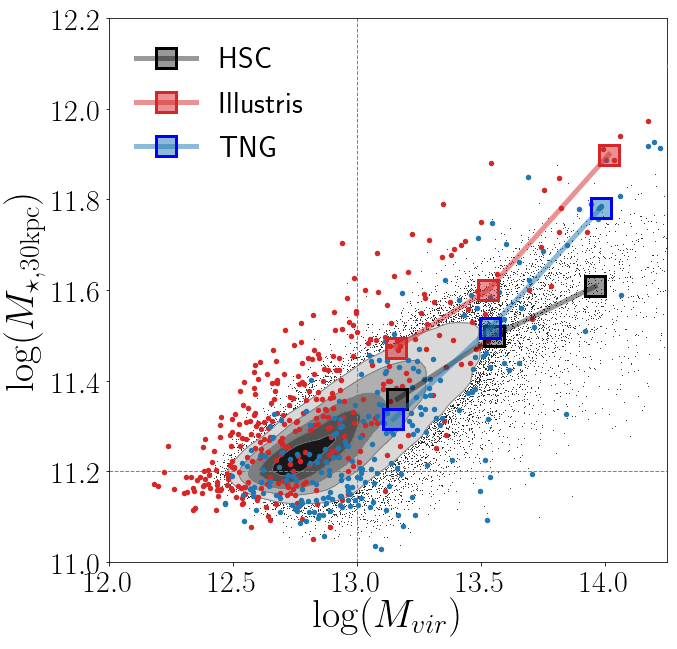

In [11]:
make_Mstar_Mhalo_plot(HSC_data, 30, Illustris_data = illustris_masses,
                     TNG_data = tng_masses)

/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:15: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


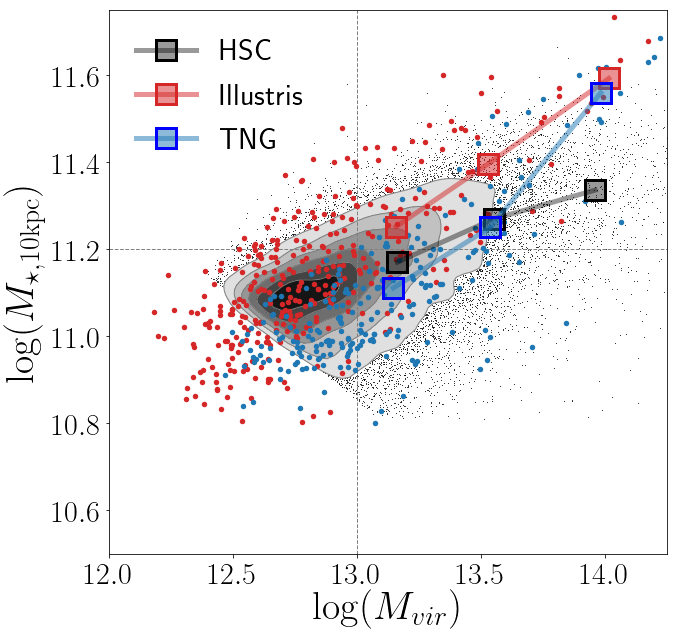

In [12]:
make_Mstar_Mhalo_plot(HSC_data,  10, Illustris_data = illustris_masses,
                     TNG_data = tng_masses)